<a href="https://colab.research.google.com/github/GabrielCdev/titanic_disaster_analysis/blob/main/Titanic_with_IA_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Atividade 02

Base para a atividade: https://www.kaggle.com/competitions/titanic/data

###....:::: Membros ::::....

Áureo Ramos

Gabriel Borges Calheiros

Izadora de Oliveira Machado Paim

Laianne Protásio

In [1]:
# bibliotecas principais
import numpy as np
import pandas as pd
pd.set_option("display.precision", 2)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from numpy.random import RandomState

In [2]:
# Carga dos dados .csv
titanic_df = pd.read_csv('https://raw.githubusercontent.com/GabrielCdev/titanic_disaster_analysis/main/titanic/train.csv')

In [3]:
titanic_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C


In [4]:
#Separando o dataset em treino e teste

rng = RandomState(seed=2)

train_df = titanic_df.sample(frac=0.8, random_state=rng)
test_df = titanic_df.loc[~titanic_df.index.isin(train_df.index)]

In [5]:
#train_df = titanic_df
#test_df = titanic_df

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 713 entries, 707 to 421
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  713 non-null    int64  
 1   Survived     713 non-null    int64  
 2   Pclass       713 non-null    int64  
 3   Name         713 non-null    object 
 4   Sex          713 non-null    object 
 5   Age          569 non-null    float64
 6   SibSp        713 non-null    int64  
 7   Parch        713 non-null    int64  
 8   Ticket       713 non-null    object 
 9   Fare         713 non-null    float64
 10  Cabin        161 non-null    object 
 11  Embarked     712 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.4+ KB


### Funções de Pré-processamento das bases

In [7]:
def preprocessing(dataset: pd.DataFrame, mean_ages: pd.Series = pd.Series()):
  # Alterando o tipo de dados do dataset
  dataset['Name'] = dataset['Name'].astype('string')
  dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1}).astype(int)
  dataset['Cabin'] = dataset['Cabin'].astype('category')
  dataset['Embarked'] = dataset['Embarked'].astype('category')
  
  # Criando uma nova coluna para Pronomes de Tratamento
  dataset['Treatment pronouns'] = dataset['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

  # Criando uma nova coluna para verificar os passageiros que tinham parentes à bordo
  dataset.insert(len(dataset.columns),'Relatives',np.nan)
  dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']
  dataset['Relatives'] = dataset.Relatives.apply(lambda x: 0 if x == 0 else 1)

  # Removendo colunas do dataset
  dataset.drop(columns='PassengerId', inplace=True)
  dataset.drop(columns='Ticket', inplace=True)
  dataset.drop(columns='Name', inplace=True)
  dataset.drop(columns='SibSp', inplace=True)
  dataset.drop(columns='Parch', inplace=True)
  dataset.drop(columns='Cabin', inplace=True)
  dataset.drop(columns='Embarked', inplace=True)
  
  if (mean_ages.empty):
    output, mean_ages = completeNullAge_train(dataset)
  else:
    output = completeNullAge_test(dataset, mean_ages)

  # Agrupando idades em classes
  classes = [0, 5, 10, 18, 29, 100]
  labels = ['Baby', 'Children', 'Young', 'Adults', 'Aged']
  classes = pd.cut(x=dataset.Age, bins=classes, labels=labels)
  dataset['Age'] = classes

  # Mapeando os Pronomes de Tratamento
  dataset['Treatment pronouns'] = dataset['Treatment pronouns'].map({'Mr': 0, 'Mrs': 1, 'Miss': 2, 'Master': 3, 'Others': 4}).astype(int)

  # Mapeando as Idades
  dataset['Age'] = dataset['Age'].map({'Baby': 0, 'Children': 1, 'Young': 2, 'Adults': 3, 'Aged': 4}).astype(int)

  # Mapeando o preço dos tickets
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
  dataset.loc[ dataset['Fare'].isna(), 'Fare'] = 0
  dataset['Fare'] = dataset['Fare'].astype(int)

  return output, mean_ages

<ipython-input-7-af44058a8132>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def preprocessing(dataset: pd.DataFrame, mean_ages: pd.Series = pd.Series()):


In [8]:
#Completando as idades faltantes/NaN a partir da média das idades com base em Pclass e Treatment pronouns
def completeNullAge_train(dataset: pd.DataFrame):
  #Substituindo os Treatment Pronouns menos frequentes por Others
  threshold = dataset['Treatment pronouns'].value_counts()[3]
  dataset.loc[dataset['Treatment pronouns'].value_counts()[dataset['Treatment pronouns']].values < threshold, 'Treatment pronouns'] = 'Others'
  dataset_mean_age = dataset.groupby(['Treatment pronouns','Pclass'])['Age'].mean()
  x = dataset['Treatment pronouns'].unique()
  y = dataset['Pclass'].unique()
  w = [ (a,b) for a in x for b in y ]
  z = pd.MultiIndex.from_tuples(w, names=['Treatment pronouns','Pclass'])
  series = pd.Series(np.nan, index=z)
  for j in dataset_mean_age.index:
    series[j] = dataset_mean_age[j]
  dataset_mean_age = series
  dataset_mean_age.fillna(dataset_mean_age.mean(), inplace=True)
  for i in range(len(dataset['Age'])):
    pclass = dataset['Pclass'].iloc[i]
    tp = dataset['Treatment pronouns'].iloc[i]  
    if pd.isnull(dataset['Age'].iloc[i]):
      dataset['Age'].iloc[i] = dataset_mean_age[tp,pclass]
  
  return dataset, dataset_mean_age

In [9]:
#Completando as idades faltantes/NaN a partir da média das idades com base em Pclass e Treatment pronouns
def completeNullAge_test(dataset: pd.DataFrame, dataset_mean_age):
  #Substituindo os Treatment Pronouns menos frequentes por Others
  allowed_vals = []
  temp = set()
  for inner in dataset_mean_age.index:
    for elem in inner:
      if (not elem in temp) & (isinstance(elem, str)):
        temp.add(elem)
        allowed_vals.append(elem)
  
  dataset.loc[~dataset['Treatment pronouns'].isin(allowed_vals), 'Treatment pronouns'] = 'Others'

  for i in range(len(dataset['Age'])):
    if pd.isnull(dataset['Age'].iloc[i]) & ~pd.isnull(dataset['Pclass'].iloc[i]) & ~pd.isnull(dataset['Treatment pronouns'].iloc[i]):
      pclass = dataset['Pclass'].iloc[i]
      tp = dataset['Treatment pronouns'].iloc[i]
      dataset['Age'].iloc[i] = mean_ages[tp,pclass]
    elif pd.isnull(dataset['Age'].iloc[i]) & ~pd.isnull(dataset['Pclass'].iloc[i]) & pd.isnull(dataset['Treatment pronouns'].iloc[i]):
      print('none1') #não foi desenvolvido porque essa hipótese não ocorre no dataset, mas poderia ocorrer numa situação real
    elif pd.isnull(dataset['Age'].iloc[i]) & pd.isnull(dataset['Pclass'].iloc[i]) & ~pd.isnull(dataset['Treatment pronouns'].iloc[i]):
      print('none2') #não foi desenvolvido porque essa hipótese não ocorre no dataset, mas poderia ocorrer numa situação real
    elif pd.isnull(dataset['Age'].iloc[i]) & pd.isnull(dataset['Pclass'].iloc[i]) & pd.isnull(dataset['Treatment pronouns'].iloc[i]):
      print('none3') #não foi desenvolvido porque essa hipótese não ocorre no dataset, mas poderia ocorrer numa situação real

  return dataset

##Aplicando o pré-processamento

In [10]:
mean_ages = preprocessing(train_df)[1]
preprocessing(test_df, mean_ages)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-7-af44058a8132>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Name'] = dataset['Name'].astype('string')
<ipython-input-7-af44058a8132>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

(     Survived  Pclass  Sex  Age  Fare  Treatment pronouns  Relatives
 0           0       3    0    3     0                   0          1
 8           1       3    1    3     1                   1          1
 19          1       3    1    4     0                   1          0
 21          1       2    0    4     1                   0          0
 26          0       3    0    3     0                   0          0
 ..        ...     ...  ...  ...   ...                 ...        ...
 879         1       1    1    4     3                   1          1
 883         0       2    0    3     1                   0          0
 884         0       3    0    3     0                   0          0
 885         0       3    1    4     2                   1          1
 888         0       3    1    2     2                   2          1
 
 [178 rows x 7 columns], Treatment pronouns  Pclass
 Mr                  1         41.41
                     3         28.98
                     2         3

In [11]:
train_df.head(5)

,Survived,Pclass,Sex,Age,Fare,Treatment pronouns,Relatives
707,1,1,0,4,2,0,0
37,0,3,0,3,1,0,0
615,1,2,1,3,3,2,1
169,0,3,0,3,3,0,0
68,1,3,1,2,1,2,1


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 0 to 888
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Survived            178 non-null    int64
 1   Pclass              178 non-null    int64
 2   Sex                 178 non-null    int64
 3   Age                 178 non-null    int64
 4   Fare                178 non-null    int64
 5   Treatment pronouns  178 non-null    int64
 6   Relatives           178 non-null    int64
dtypes: int64(7)
memory usage: 11.1 KB


In [13]:
test_df

,Survived,Pclass,Sex,Age,Fare,Treatment pronouns,Relatives
0,0,3,0,3,0,0,1
8,1,3,1,3,1,1,1
19,1,3,1,4,0,1,0
21,1,2,0,4,1,0,0
26,0,3,0,3,0,0,0
...,...,...,...,...,...,...,...
879,1,1,1,4,3,1,1
883,0,2,0,3,1,0,0
884,0,3,0,3,0,0,0
885,0,3,1,4,2,1,1


In [14]:
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

##Aplicando os classificadores

In [15]:
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

###Cross-Validation

In [16]:
cv = KFold(n_splits=10)
accuracies = list()
max_attributes = len(list(test_df))
depth_range = (1, max_attributes + 1)

In [17]:
for depth in depth_range:
  fold_accuracy = []
  tree_model = tree.DecisionTreeClassifier(max_depth = depth)
  
  for train_fold, valid_fold in cv.split(train_df):
    f_train = train_df.loc[train_fold]
    f_valid = train_df.loc[valid_fold]

    model = tree_model.fit(X = f_train.drop(['Survived'], axis=1), 
                            y = f_train["Survived"])
    valid_acc = model.score(X = f_valid.drop(['Survived'], axis=1), 
                            y = f_valid["Survived"])
    fold_accuracy.append(valid_acc)

fold_accuracy

[0.8055555555555556,
 0.8333333333333334,
 0.75,
 0.7746478873239436,
 0.9014084507042254,
 0.7887323943661971,
 0.7746478873239436,
 0.7746478873239436,
 0.7887323943661971,
 0.8309859154929577]

###Árvore de Decisão

In [18]:
X_train = train_df.iloc[:, 1:]
Y_train = train_df.iloc[:, 0]
X_test = test_df.iloc[:,1:]
Y_test = test_df.iloc[:,0]

In [19]:
decision_tree = DecisionTreeClassifier(max_depth = 5)
decision_tree.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=5)

In [20]:
acc_decision_tree_train = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree_train

83.45

In [21]:
acc_decision_tree_test = round(decision_tree.score(X_test, Y_test) * 100, 2)
acc_decision_tree_test

79.21

###Random Forest

In [22]:
forest = RandomForestClassifier(n_estimators=100, random_state=100)

forest.fit(X_train, Y_train)
forest.predict(X_test)
forest

RandomForestClassifier(random_state=100)

In [23]:
acc_random_forest = round(forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

85.27

In [24]:
acc_random_forest = round(forest.score(X_test, Y_test) * 100, 2)
acc_random_forest

79.78

###kNN

In [25]:
k_range = range(1, 26)
scores = []

for k in k_range:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, Y_train)
  y_pred = knn.predict(X_test)
  scores.append(metrics.accuracy_score(Y_test, y_pred))

scores

[0.7808988764044944,
 0.7752808988764045,
 0.7808988764044944,
 0.7752808988764045,
 0.7921348314606742,
 0.7640449438202247,
 0.7808988764044944,
 0.7921348314606742,
 0.7696629213483146,
 0.7696629213483146,
 0.7752808988764045,
 0.7752808988764045,
 0.7752808988764045,
 0.7808988764044944,
 0.7808988764044944,
 0.7921348314606742,
 0.7921348314606742,
 0.7752808988764045,
 0.7696629213483146,
 0.7808988764044944,
 0.7752808988764045,
 0.7752808988764045,
 0.7696629213483146,
 0.7752808988764045,
 0.7808988764044944]

In [26]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)
acc_knn = metrics.accuracy_score(Y_test, y_pred)
acc_knn

0.7921348314606742

###Matriz de Confusão

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_predict

In [28]:
def model_evaluation(classifier, y_test=None, x_test=None):
    cm = confusion_matrix(y_test,classifier.predict(x_test))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = 'Blues',fmt ='')
    
    tn,fp,fn,tp = cm.flatten()
    
    print('PRECISION : ','{0:.2%}'.format(tp/(tp + fp)))
    print('RECALL : ','{0:.2%}'.format(tp/(tp + fn)))

PRECISION :  78.43%
RECALL :  60.61%


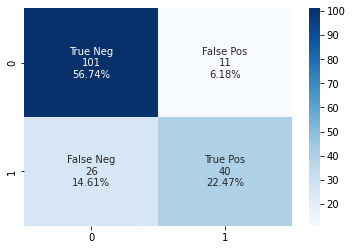

In [29]:
# Decision Tree
model_evaluation(decision_tree, Y_test, X_test)

In [30]:
predictions_dt = cross_val_predict(decision_tree, X_test, Y_test, cv=3)

In [31]:
f1_score(Y_test, predictions_dt)

0.7301587301587302

PRECISION :  76.79%
RECALL :  65.15%


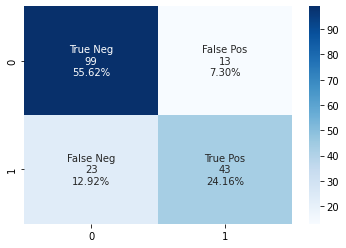

In [32]:
# Random Forest
model_evaluation(forest, Y_test, X_test)

In [33]:
predictions_rf = cross_val_predict(forest, X_test, Y_test, cv=3)

In [34]:
f1_score(Y_test, predictions_rf)

0.6814814814814815

PRECISION :  80.85%
RECALL :  57.58%


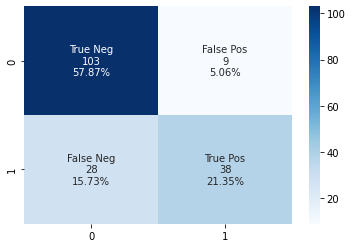

In [35]:
# kNN
model_evaluation(knn, Y_test, X_test)

In [36]:
predictions_knn = cross_val_predict(knn, X_test, Y_test, cv=3)

In [37]:
f1_score(Y_test, predictions_knn)

0.5504587155963303

# Dataset de Teste

In [38]:
titanic_test = pd.read_csv('https://raw.githubusercontent.com/GabrielCdev/titanic_disaster_analysis/main/titanic/test.csv')

In [39]:
passengerID = titanic_test['PassengerId']

In [40]:
preprocessing(titanic_test, mean_ages)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


(     Pclass  Sex  Age  Fare  Treatment pronouns  Relatives
 0         3    0    4     0                   0          0
 1         3    1    4     0                   1          1
 2         2    0    4     1                   0          0
 3         3    0    3     1                   0          0
 4         3    1    3     1                   1          1
 ..      ...  ...  ...   ...                 ...        ...
 413       3    0    3     1                   0          0
 414       1    1    4     3                   4          0
 415       3    0    4     0                   0          0
 416       3    0    3     1                   0          0
 417       3    0    1     2                   3          1
 
 [418 rows x 6 columns], Treatment pronouns  Pclass
 Mr                  1         41.41
                     3         28.98
                     2         33.35
 Miss                1         29.91
                     3         15.72
                     2         24.52
 Oth

In [41]:
result_forest = forest.predict(titanic_test)
result_dt = decision_tree.predict(titanic_test)
result_kNN = knn.predict(titanic_test)

In [42]:
passengerID.to_frame()
titanic_test = passengerID.to_frame().join(titanic_test)

In [43]:
submission = pd.DataFrame({
  "PassengerId": titanic_test["PassengerId"],
  "Survived": result_forest
})

submission.to_csv('submission_forest.csv', index=False)
from google.colab import files
files.download('submission_forest.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
submission = pd.DataFrame({
  "PassengerId": titanic_test["PassengerId"],
  "Survived": result_kNN
})

submission.to_csv('submission_kNN.csv', index=False)
from google.colab import files
files.download('submission_kNN.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [45]:
submission = pd.DataFrame({
  "PassengerId": titanic_test["PassengerId"],
  "Survived": result_dt
})

submission.to_csv('submission_dt.csv', index=False)
from google.colab import files
files.download('submission_dt.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Score on Kaggle: Radom Forest 0.7775; kNN 0.7751; Decision Tree 0.7799.

# Comentários

- Após o uso da matriz de confusão, viu-se um recall maior que 65%, o que mostra que o modelo foi capaz de identificar muitos exemplos positivos. Sendo o maior Recall vindo do algoritmo Random Forest.

- A precisão do modelo manteve-se maior que 80%, sendo a maior vista no uso do algoritmo KNN.

- Árvore de Decisão:
 - 101 passageiros foram classificados corretamente como não sobreviventes e 26 foram classificados de forma errada como não sobreviventes.
  - 11 passageiros classificados de forma errada como sobreviventes e 40 corretamente classificados como sobreviventes.
  - A precisão do modelo prevê a sobrevivência de passageiros de forma correta em quase 78% das vezes.
  - O Recall comprova a assertividade dos que sobreviveram em 60% das vezes.
  - F1 Score foi de aproximadamente 73%.

- Random Forest:
 - 99 passageiros foram classificados corretamente como não sobreviventes e 23 foram classificados de forma errada como não sobreviventes.
  - 13 passageiros classificados de forma errada como sobreviventes e 43 corretamente classificados como sobreviventes.
  - A precisão do modelo prevê a sobrevivência de passageiros de forma correta em 80% das vezes.
  - O Recall comprova a assertividade dos que sobreviveram com quase 77%.
  - F1 Score foi de aproximadamente 68%.

- kNN:
  - 103 passageiros foram classificados corretamente como não sobreviventes e 28 foram classificados de forma errada como não sobreviventes.
  - 8 passageiros classificados de forma errada como sobreviventes e 38 corretamente classificados como sobreviventes.
  - A precisão do modelo prevê a sobrevivência de passageiros de forma correta em 81% das vezes.
  - O Recall comprova a assertividade dos que sobreviveram com quase 58%.
  - F1 Score foi de aproximadamente 55%.